In [3]:
import anndata as ad
import numpy as np
from matplotlib import ticker
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from seaborn import color_palette, light_palette
import math
import re
import pandas as pd
import pickle

Load clustered model output and initialise the report.

In [4]:
run_label = "light_cameo"
adata_filename = "spatial_8327576.h5ad"
print(f"Generating report for run {run_label}.")
adata = ad.read_h5ad(f"artefacts/{run_label}/{adata_filename}")

Generating report for run light_cameo.


In [5]:
n_genes = len(adata.var_names)
n_cells = len(adata.obs_names)
print(f"This model ran using {n_genes} genes and {n_cells} cells.")

This model ran using 236 genes and 1091280 cells.


Excluding cells which are not assigned to a primary niche.

In [6]:
adata = adata[adata.obs["nichecompass_latent_cluster"] != "unassigned"]

# Niche composition

Visualise the latent space for primary and sub niches.

In [7]:
umap_embedding = adata.obsm["X_umap"]

In [8]:
# set interactive color

inactive_color = "#f0f0f0"

# set color map for primary niches

niche_labels = adata.obs["nichecompass_latent_cluster"].astype(str).unique().tolist()

def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(l, key = alphanum_key)

niche_labels = natural_sort(niche_labels)
niche_colors = color_palette("husl", len(niche_labels))
niche_color_map = {key: value for key, value in zip(niche_labels, niche_colors)}

# set color map for sub niches

sub_niche_color_map = {}
for niche_label in niche_labels:
    niche_color = niche_color_map[niche_label]
    adata_sample = adata[adata.obs["nichecompass_latent_cluster"] == niche_label]
    sub_niche_labels = adata_sample.obs["nichecompass_latent_sub_cluster_label"].astype(str).unique().tolist()
    sub_niche_labels.sort()
    sub_niche_colors = light_palette(niche_color, len(sub_niche_labels) + 2, reverse=True)
    sub_niche_color_map_sample = {key: value for key, value in zip(sub_niche_labels[:len(sub_niche_labels)], sub_niche_colors)}
    sub_niche_color_map.update(sub_niche_color_map_sample)

Text(0, 0.5, 'UMAP 2')

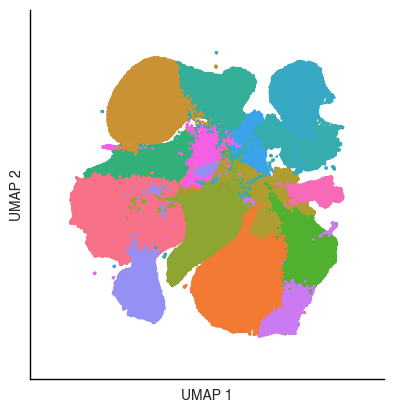

In [9]:
fig, ax = plt.subplots()
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=adata.obs["nichecompass_latent_cluster"].astype(str).map(niche_color_map),
    s=1
)
ax.grid(False)
ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1)
ax.spines[['left', 'bottom']].set_color("black")
ax.set_xticks([])
ax.set_yticks([])

hfont = {'fontname':'Helvetica'}

ax.set_aspect('equal')
ax.margins(0.15)
plt.xlabel("UMAP 1", labelpad=7, **hfont)
plt.ylabel("UMAP 2", **hfont)

Text(0, 0.5, 'Number of cells')

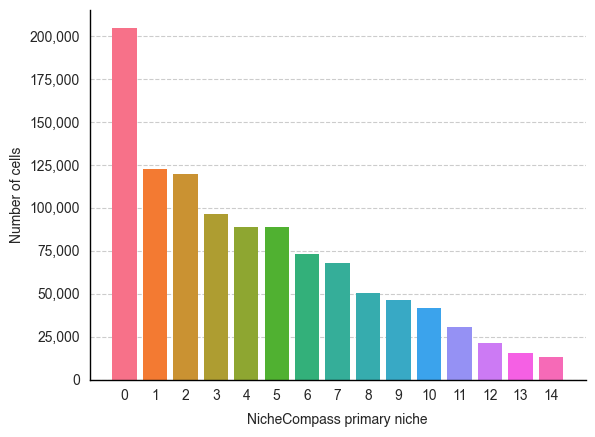

In [10]:
niche_cell_frequency = adata.obs["nichecompass_latent_cluster"].value_counts()
fig, ax = plt.subplots()
ax.bar(niche_cell_frequency.index, niche_cell_frequency, color=[niche_color_map[niche_label] for niche_label in niche_cell_frequency.index.tolist()], edgecolor="none")

ax.grid(which='major', axis='y', linestyle='--')
ax.grid(False, axis='x')
ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1)
ax.spines[['left', 'bottom']].set_color("black")

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

hfont = {'fontname':'Helvetica'}
plt.xlabel("NicheCompass primary niche", labelpad=7, **hfont)
plt.ylabel("Number of cells", **hfont)

Text(0, 0.5, 'Number of cells')

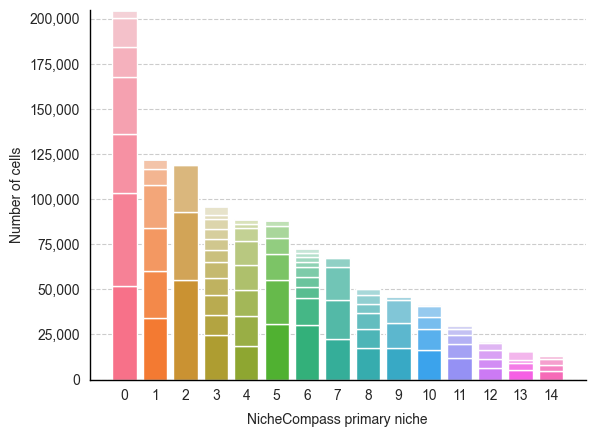

In [11]:
cluster_composition = adata.obs.groupby(["nichecompass_latent_cluster", "nichecompass_latent_sub_cluster_label"], observed=False).size().unstack()

categories = cluster_composition.axes[1].tolist()
clusters = cluster_composition.axes[0].tolist()

fig, ax = plt.subplots()
bottom = np.zeros(len(clusters))
for batch in categories:
    ax.bar(clusters, cluster_composition[batch], color=sub_niche_color_map[batch], label=batch, bottom=bottom)
    bottom += cluster_composition[batch]

ax.grid(which='major', axis='y', linestyle='--')
ax.grid(False, axis='x')
ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1)
ax.spines[['left', 'bottom']].set_color("black")

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
hfont = {'fontname':'Helvetica'}
plt.xlabel("NicheCompass primary niche", labelpad=7, **hfont)
plt.ylabel("Number of cells", **hfont)


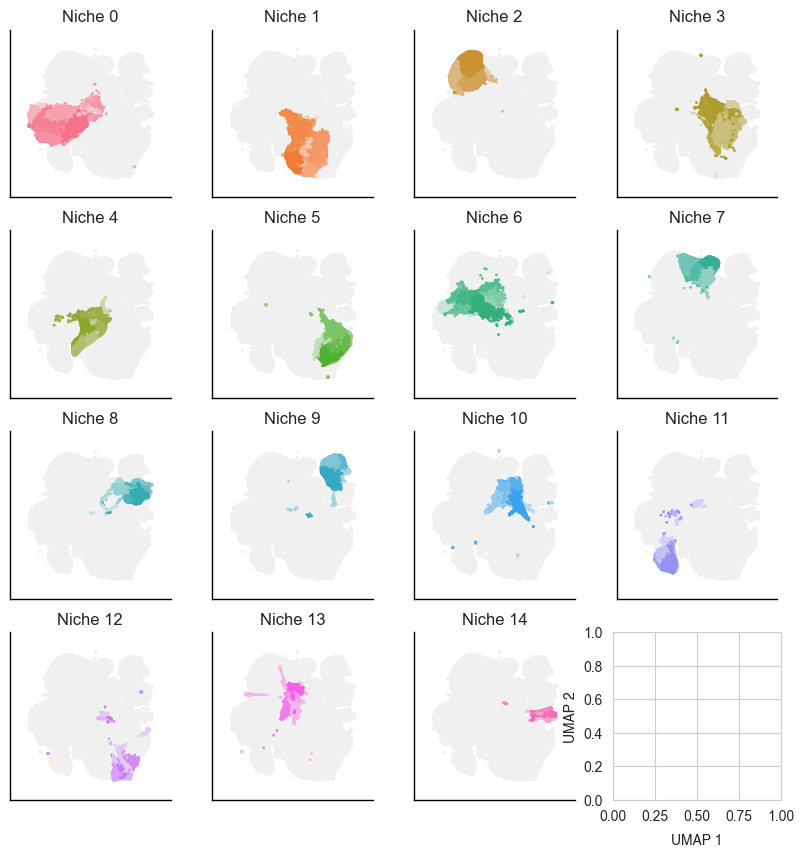

In [12]:
clusters = adata.obs["nichecompass_latent_cluster"].unique().tolist()
clusters = natural_sort(clusters)

fig, axs = plt.subplots(4, math.ceil(len(clusters)/4))

for cluster, ax in zip(clusters, axs.flat):
    adata_subset = adata[adata.obs["nichecompass_latent_cluster"] == cluster]
    umap_embedding_subset = adata_subset.obsm["X_umap"]
    
    ax.scatter(
        umap_embedding[:, 0],
        umap_embedding[:, 1],
        c=inactive_color,
        s=1
    )
    ax.scatter(
        umap_embedding_subset[:, 0],
        umap_embedding_subset[:, 1],
        c=adata_subset.obs["nichecompass_latent_sub_cluster_label"].astype(str).map(sub_niche_color_map),
        s=1
    )
    ax.grid(False)
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines[['left', 'bottom']].set_linewidth(1)
    ax.spines[['left', 'bottom']].set_color("black")
    ax.set_xticks([])
    ax.set_yticks([])
    
    hfont = {'fontname':'Helvetica'}

    ax.set_title(f"Niche {cluster}")
    
    ax.set_aspect('equal')
    ax.margins(0.15)
    plt.xlabel("UMAP 1", labelpad=7, **hfont)
    plt.ylabel("UMAP 2", **hfont)
    
fig.set_figheight(10)
fig.set_figwidth(10)

Show the number of cells in each primary niche.

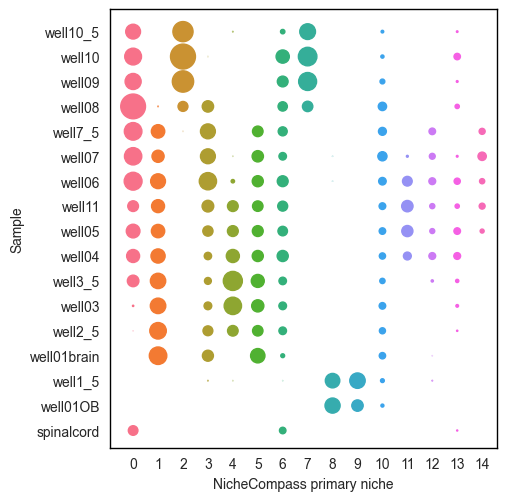

In [13]:
sample_order = [
                'spinalcord',
                'well01OB',
                'well1_5',
                'well01brain',
                'well2_5',
                'well03',
                'well3_5',
                'well04',
                'well05',
                'well11',
                'well06',
                'well07',
                'well7_5',
                'well08',
                'well09',
                'well10',
                'well10_5'
]

cluster_composition = adata.obs.groupby(["label", "nichecompass_latent_cluster"], observed=False).size().unstack()
cluster_composition = cluster_composition.loc[sample_order]

cluster_composition_np = cluster_composition.to_numpy()

N = cluster_composition_np.shape[0]
M = cluster_composition_np.shape[1]
xlabels = cluster_composition.columns.tolist()
ylabels = cluster_composition.index.values.tolist()

categories = adata.obs["nichecompass_latent_cluster"].astype(str).fillna("Unknown").unique().tolist()
colours = color_palette("colorblind", len(categories))
colour_map = {key: value for key, value in zip(categories, colours)}

x, y = np.meshgrid(np.arange(M), np.arange(N))

area = cluster_composition_np
c = [niche_color_map[xlabels[i]] for i in x.flat]

fig, ax = plt.subplots()

radius = np.sqrt(area/np.pi)
R = radius/radius.max()/2

circles = [plt.Circle((j,i), radius=r, color=c) for r, j, i, c in zip(R.flat, x.flat, y.flat, c)]
collection = PatchCollection(circles, match_original=True)
ax.add_collection(collection)

ax.set(xticks=np.arange(M), yticks=np.arange(N), xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(False)

hfont = {'fontname':'Helvetica'}

plt.ylabel("Sample", **hfont)
plt.xlabel("NicheCompass primary niche", **hfont)

ax.set_aspect('equal')

ax.grid(False)
ax.spines[['left', 'bottom', "right", "top"]].set_linewidth(1)
ax.spines[['left', 'bottom', "right", "top"]].set_color("black")

ax.margins(0.03)

fig.set_figheight(20)
fig.set_figwidth(5)

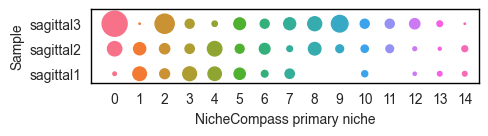

In [14]:
sample_order = [
        'sagittal1',
        'sagittal2',
        'sagittal3'
]

cluster_composition = adata.obs.groupby(["label", "nichecompass_latent_cluster"], observed=False).size().unstack()
cluster_composition = cluster_composition.loc[sample_order]

cluster_composition_np = cluster_composition.to_numpy()

N = cluster_composition_np.shape[0]
M = cluster_composition_np.shape[1]
xlabels = cluster_composition.columns.tolist()
ylabels = cluster_composition.index.values.tolist()

categories = adata.obs["nichecompass_latent_cluster"].astype(str).fillna("Unknown").unique().tolist()
colours = color_palette("colorblind", len(categories))
colour_map = {key: value for key, value in zip(categories, colours)}

x, y = np.meshgrid(np.arange(M), np.arange(N))

area = cluster_composition_np
c = [niche_color_map[xlabels[i]] for i in x.flat]

fig, ax = plt.subplots()

radius = np.sqrt(area/np.pi)
R = radius/radius.max()/2

circles = [plt.Circle((j,i), radius=r, color=c) for r, j, i, c in zip(R.flat, x.flat, y.flat, c)]
collection = PatchCollection(circles, match_original=True)
ax.add_collection(collection)

ax.set(xticks=np.arange(M), yticks=np.arange(N), xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(False)

hfont = {'fontname':'Helvetica'}

plt.ylabel("Sample", **hfont)
plt.xlabel("NicheCompass primary niche", **hfont)

ax.set_aspect('equal')

ax.grid(False)
ax.spines[['left', 'bottom', "right", "top"]].set_linewidth(1)
ax.spines[['left', 'bottom', "right", "top"]].set_color("black")

ax.margins(0.03)

fig.set_figheight(20)
fig.set_figwidth(5)

Show the cell composition of each niche.

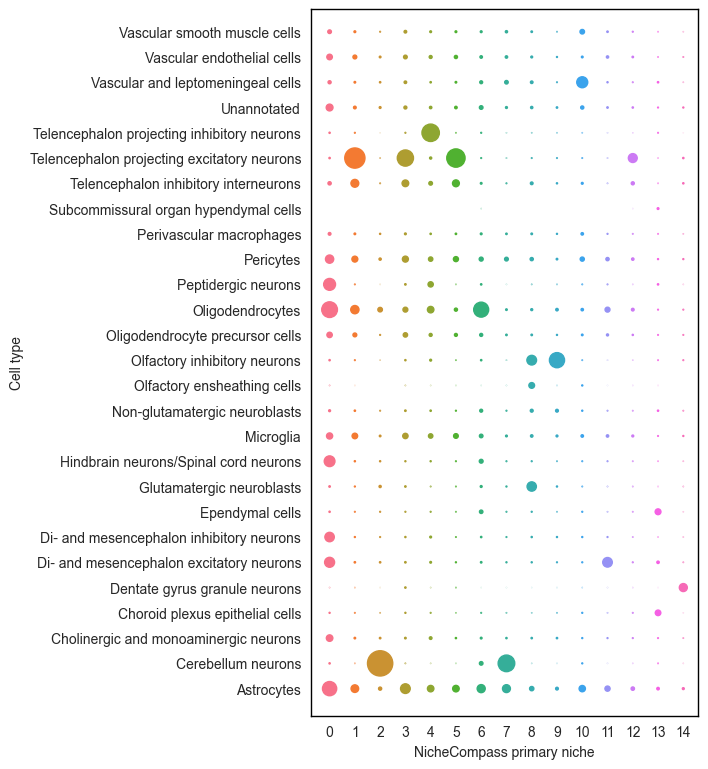

In [15]:
cluster_composition = adata.obs.groupby(["Main_molecular_cell_type", "nichecompass_latent_cluster"], observed=False).size().unstack()

cluster_composition_np = cluster_composition.to_numpy()

N = cluster_composition_np.shape[0]
M = cluster_composition_np.shape[1]
xlabels = cluster_composition.columns.tolist()
ylabels = cluster_composition.index.values.tolist()

categories = adata.obs["nichecompass_latent_cluster"].astype(str).fillna("Unknown").unique().tolist()
colours = color_palette("colorblind", len(categories))

x, y = np.meshgrid(np.arange(M), np.arange(N))

area = cluster_composition_np
c = [niche_color_map[xlabels[i]] for i in x.flat]

fig, ax = plt.subplots()

radius = np.sqrt(area/np.pi)
R = radius/radius.max()/2

circles = [plt.Circle((j,i), radius=r, color=c) for r, j, i, c in zip(R.flat, x.flat, y.flat, c)]
collection = PatchCollection(circles, match_original=True)
ax.add_collection(collection)

ax.set(xticks=np.arange(M), yticks=np.arange(N), xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(False)


hfont = {'fontname':'Helvetica'}

plt.ylabel("Cell type", **hfont)
plt.xlabel("NicheCompass primary niche", **hfont)

ax.set_aspect('equal')

ax.grid(False)
ax.spines[['left', 'bottom', "right", "top"]].set_linewidth(1)
ax.spines[['left', 'bottom', "right", "top"]].set_color("black")

ax.margins(0.03)

fig.set_figheight(20)
fig.set_figwidth(5)


Generate a 3D plot based on manual tissue section alignment.

In [16]:
rotation = {
    "sagittal1": 270,
    "sagittal2": 90,
    "sagittal3": 90,
    "spinalcord": 0,
    "well01OB": 90,
    "well1_5": 0,
    "well01brain": 90,
    "well2_5": 180,
    "well03": 90,
    "well3_5": 180,
    "well04": 270,
    "well05": 270,
    "well06": 90,
    "well07": 270,
    "well7_5": 0,
    "well08": 270,
    "well09": 270,
    "well10": 270,
    "well10_5": 0,
    "well11": 90
}

scale_x = {
    "sagittal1": -1,
    "sagittal2": -1,
    "sagittal3": -1,
    "spinalcord": -1,
    "well01OB": -1,
    "well1_5": -1,
    "well01brain": -1,
    "well2_5": -1,
    "well03": 1,
    "well3_5": -1,
    "well04": -1,
    "well05": -1,
    "well06": -1,
    "well07": -1,
    "well7_5": -1,
    "well08": -1,
    "well09": -1,
    "well10": -1,
    "well10_5": -1,
    "well11": -1
}

scale_y = {
    "sagittal1": 1,
    "sagittal2": 1,
    "sagittal3": 1,
    "spinalcord": 1,
    "well01OB": 1,
    "well1_5": 1,
    "well01brain": -1,
    "well2_5": 1,
    "well03": -1,
    "well3_5": 1,
    "well04": 1,
    "well05": 1,
    "well06": 1,
    "well07": 1,
    "well7_5": 1,
    "well08": -1,
    "well09": 1,
    "well10": 1,
    "well10_5": -1,
    "well11": 1
}

labels = adata.obs["label"].tolist()
xys = [(item[0], item[1]) for item in adata.obsm["spatial"].tolist()]

xs = adata.obsm["spatial"].transpose()[0]
ys = adata.obsm["spatial"].transpose()[1]

def rotate_origin_only(xy, radians):
    """Only rotate a point around the origin (0, 0)."""
    x, y = xy
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)
    return xx, yy

rotated_xys = [rotate_origin_only(xy, math.radians(rotation[label])) for xy, label in zip(xys, labels)]
scaled_xys = [(xy[0] * scale_x[label], xy[1] * scale_y[label]) for xy, label in zip(rotated_xys, labels)]

unified_xys = np.array([[x, y] for x, y in scaled_xys])

center_translation_x = {label: (min(unified_xys[adata.obs.label == label].T.tolist()[0]) + max(unified_xys[adata.obs.label == label].T.tolist()[0]))/2 for label in adata.obs["label"].cat.categories.tolist()}

center_translation_y = {label: (min(unified_xys[adata.obs.label == label].T.tolist()[1]) + max(unified_xys[adata.obs.label == label].T.tolist()[1]))/2 for label in adata.obs["label"].cat.categories.tolist()}

centered_xys = np.array([[xy[0] - center_translation_x[label], xy[1] - center_translation_y[label]] for xy, label in zip(unified_xys.tolist(), labels)])

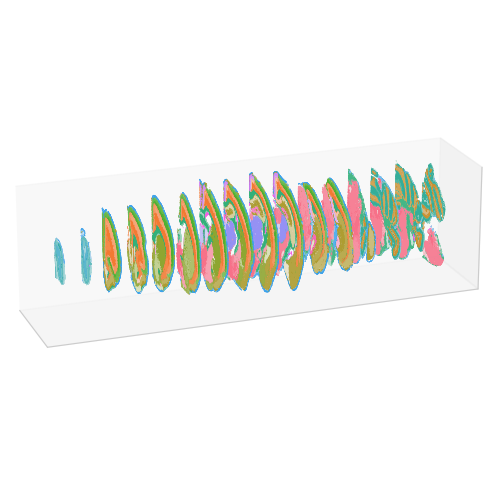

In [17]:
included_labels = adata.obs["label"].cat.categories.tolist()[4:]
included_idx = adata.obs.label.isin(included_labels).tolist()

categories = adata.obs["nichecompass_latent_sub_cluster_label"].astype(str).fillna("Unknown").unique().tolist()
colours = color_palette("colorblind", len(categories))
colour_map = {key: value for key, value in zip(categories, colours)}

z_spacing = 8000
z_order = ['sagittal1',
           'sagittal2',
           'sagittal3',
           'spinalcord',
           'well01OB',
           'well1_5',
           'well01brain',
           'well2_5',
           'well03',
           'well3_5',
           'well04',
           'well05',
           'well11',
           'well06',
           'well07',
           'well7_5',
           'well08',
           'well09',
           'well10',
           'well10_5']
zs = np.array([z_order.index(label) * z_spacing for label in labels])

xs = np.array(centered_xys.T.tolist()[0])
ys = np.array(centered_xys.T.tolist()[1])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_figheight(5)
fig.set_figwidth(30)

color = adata.obs["nichecompass_latent_sub_cluster_label"].astype(str).fillna("Unknown").map(sub_niche_color_map)
ax.scatter(xs[included_idx], zs[included_idx], ys[included_idx], s=0.2, facecolors=color[included_idx], edgecolor=None, linewidth=0, alpha=1)

ax.set_aspect('equal')
ax.view_init(20, -20)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

fig.tight_layout()

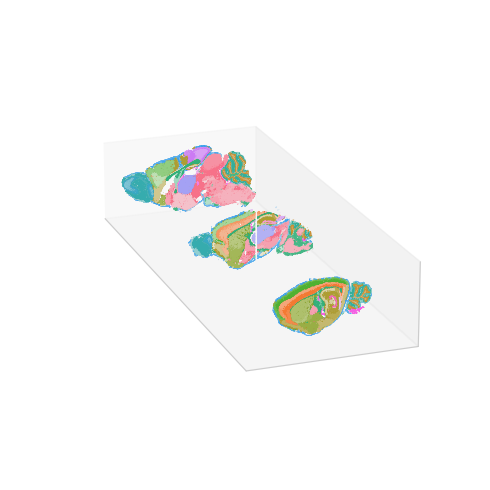

In [18]:
included_labels = adata.obs["label"].cat.categories.tolist()[:3]
included_idx = adata.obs.label.isin(included_labels).tolist()

categories = adata.obs["nichecompass_latent_sub_cluster_label"].astype(str).fillna("Unknown").unique().tolist()
colours = color_palette("colorblind", len(categories))
colour_map = {key: value for key, value in zip(categories, colours)}

z_spacing = 100000
z_order = ['sagittal3',
           'sagittal2',
           'sagittal1',
           'spinalcord',
           'well01OB',
           'well1_5',
           'well01brain',
           'well2_5',
           'well03',
           'well3_5',
           'well04',
           'well05',
           'well11',
           'well06',
           'well07',
           'well7_5',
           'well08',
           'well09',
           'well10',
           'well10_5']
zs = np.array([z_order.index(label) * z_spacing for label in labels])

xs = np.array(centered_xys.T.tolist()[0])
ys = np.array(centered_xys.T.tolist()[1])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_figheight(5)
fig.set_figwidth(30)

color = adata.obs["nichecompass_latent_sub_cluster_label"].astype(str).fillna("Unknown").map(sub_niche_color_map)
ax.scatter(zs[included_idx], xs[included_idx], ys[included_idx], s=0.2, facecolors=color[included_idx], edgecolor=None, linewidth=0, alpha=1)

ax.set_aspect('equal')
ax.view_init(20, -20)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

fig.tight_layout()

# Alignment with Allen Mouse Brain Reference Atlas

Import aligned model output for the sample 'well11'.

In [19]:
well11_aligned_coordinates = pd.read_csv("spatial_8327576_well11_aligned_to_atlas.csv")
with open("alignment_cell_index.pkl", "rb") as file:
    cell_index = pickle.load(file)
allen_ontology = pd.read_csv("allen_ontology.csv")

well11_aligned_coordinates["cell_index"] = cell_index
well11_aligned_coordinates = well11_aligned_coordinates.set_index("cell_index")

well11_adata = adata[(adata.obs["label"] == "well11") & (adata.obs["nichecompass_latent_cluster"] != "unassigned")]

well11_aligned_coordinates = well11_aligned_coordinates.loc[well11_adata.obs_names]

well11_adata.obs["struct_id"] = well11_aligned_coordinates["struct_id"].tolist()
well11_adata.obs["acronym"] = well11_aligned_coordinates["acronym"].tolist()


/var/folders/6j/wv4pcvx159sg70l_vb1g7hpc0000gq/T/ipykernel_60268/4050765988.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  well11_adata.obs["struct_id"] = well11_aligned_coordinates["struct_id"].tolist()


Show spatial distribution of all sub niches.

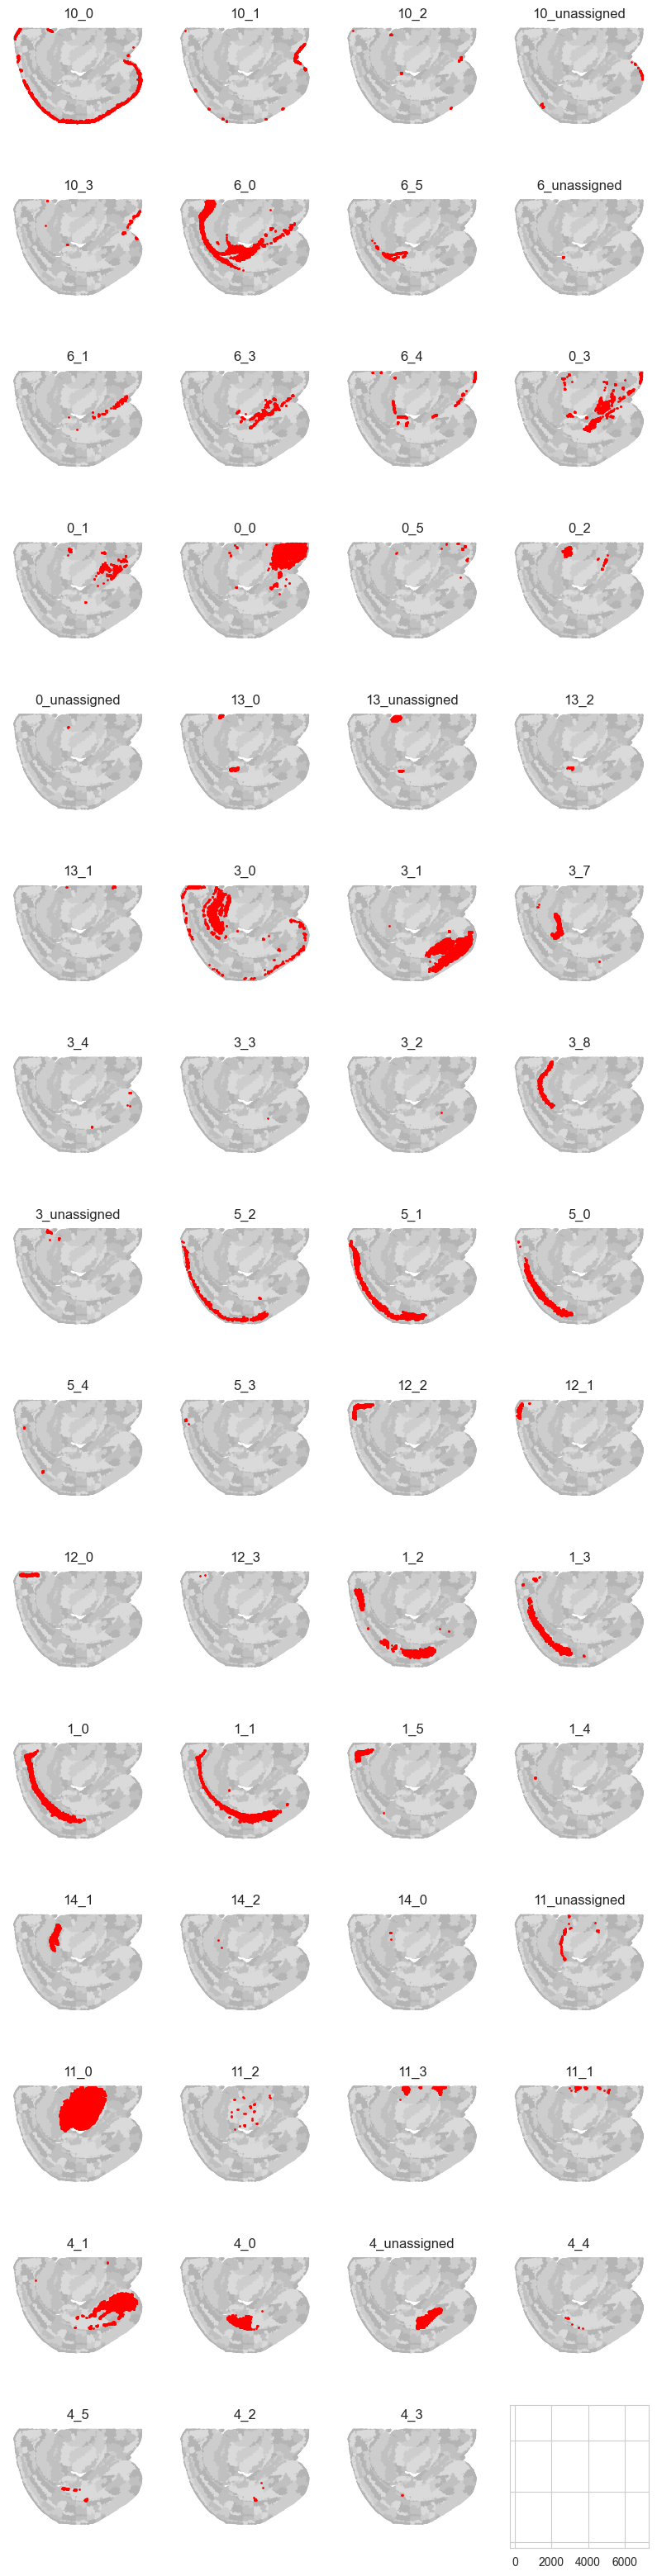

In [20]:
categories = well11_aligned_coordinates["struct_id"].astype(str).fillna("Unknown").unique().tolist()
colours = color_palette(["#b4b4b4", "#c0c0c0", "#cdcdcd", "#dadada"], len(categories))
colour_map = {key: value for key, value in zip(categories, colours)}

clusters = well11_adata.obs["nichecompass_latent_sub_cluster_label"].unique().tolist()
fig, axs = plt.subplots(math.ceil(len(clusters)/4), 4, sharex=True, sharey=True)

for ax, cluster in zip(axs.flat, clusters):

    roi = well11_aligned_coordinates[(well11_adata.obs["nichecompass_latent_sub_cluster_label"] == cluster).tolist()]
    
    ax.scatter(
        well11_aligned_coordinates["x"].tolist(),
        well11_aligned_coordinates["y"].tolist(),
        c=well11_aligned_coordinates["struct_id"].astype(str).fillna("Unknown").map(colour_map),
        s=1
    )
    
    ax.scatter(
        roi["x"].tolist(),
        roi["y"].tolist(),
        c="red",
        s=1
    )

    ax.set_title(cluster)
    ax.set_aspect('equal')
    ax.axis('off')


fig.set_figheight(40)
fig.set_figwidth(10)

Show spatial distribution for the isocortex only (feature 315).

/var/folders/6j/wv4pcvx159sg70l_vb1g7hpc0000gq/T/ipykernel_60268/3840162783.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/var/folders/6j/wv4pcvx159sg70l_vb1g7hpc0000gq/T/ipykernel_60268/3840162783.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/var/folders/6j/wv4pcvx159sg70l_vb1g7hpc0000gq/T/ipykernel_60268/3840162783.py:34: UserWarning: *c* argument looks like a single numeric RGB or RG

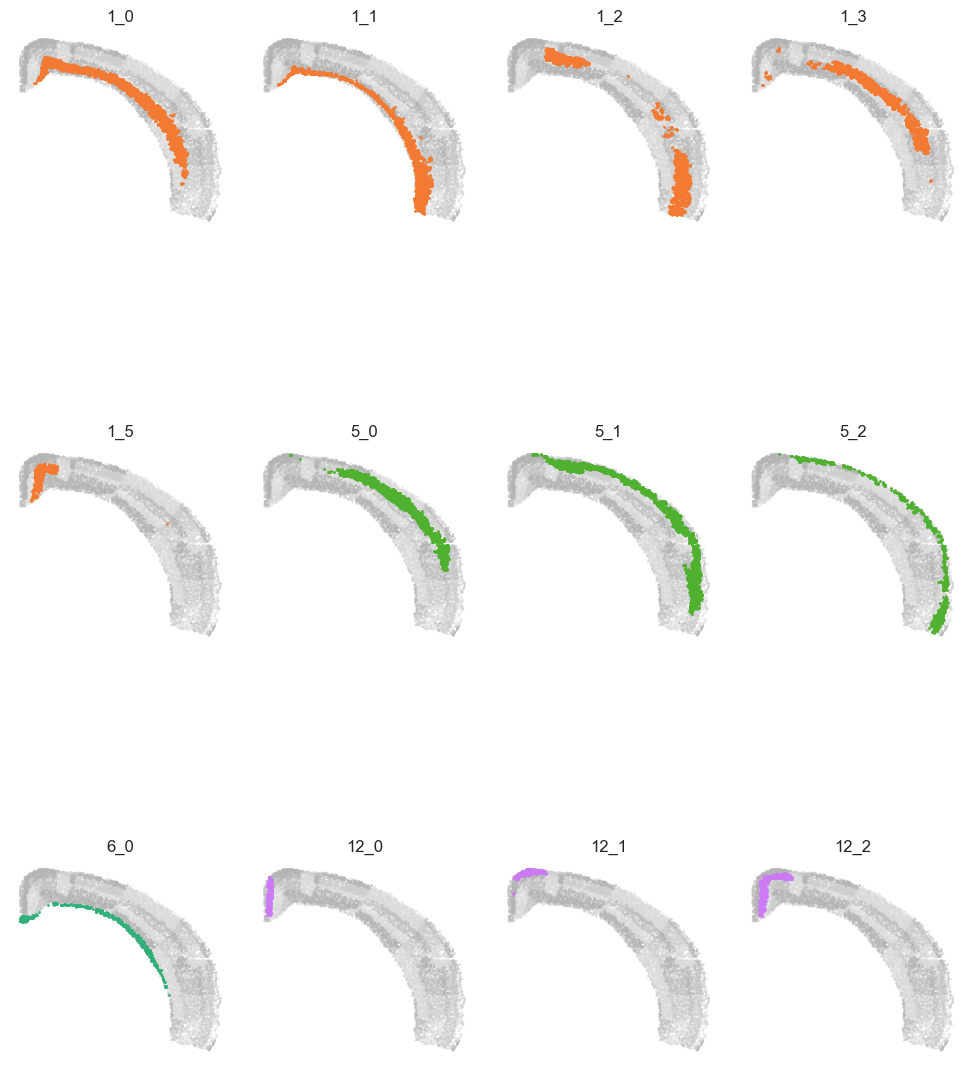

In [24]:
allen_ontology_isocortex = allen_ontology[allen_ontology["structure_id_path"].str.startswith("/997/8/567/688/695/315/")]

ontology_order_isocortex = allen_ontology_isocortex["id"].tolist()

cluster_composition = well11_adata.obs.groupby(["nichecompass_latent_sub_cluster_label", "struct_id"], observed=False).size().unstack()
cluster_composition = cluster_composition[[x for x in ontology_order_isocortex if x in cluster_composition.columns]]

clusters = cluster_composition.index[cluster_composition.sum(axis=1) > 250].tolist()

well11_aligned_coordinates_roi = well11_aligned_coordinates[well11_aligned_coordinates["struct_id"].isin(ontology_order_isocortex)]

categories = well11_aligned_coordinates_roi["struct_id"].astype(str).fillna("Unknown").unique().tolist()
colours = color_palette(["#b4b4b4", "#c0c0c0", "#cdcdcd", "#dadada"], len(categories))
colour_map = {key: value for key, value in zip(categories, colours)}

fig, axs = plt.subplots(math.ceil(len(clusters)/4), 4, sharex=True, sharey=True)

for ax, cluster in zip(axs.flat, clusters):

    roi = well11_aligned_coordinates[((well11_adata.obs["nichecompass_latent_sub_cluster_label"] == cluster) & (well11_adata.obs["struct_id"].isin(ontology_order_isocortex))).tolist()]
    
    roi_adata = well11_adata[((well11_adata.obs["nichecompass_latent_sub_cluster_label"] == cluster) & (well11_adata.obs["struct_id"].isin(ontology_order_isocortex))).tolist()]
    
    primary_cluster = roi_adata.obs["nichecompass_latent_cluster"].unique().tolist()[0]

    ax.scatter(
        [x * -1 for x in well11_aligned_coordinates_roi["y"].tolist()],
        [x * -1 for x in well11_aligned_coordinates_roi["x"].tolist()],
        c=well11_aligned_coordinates_roi["struct_id"].astype(str).fillna("Unknown").map(colour_map),
        s=0.05
    )

    ax.scatter(
        [x * -1 for x in roi["y"].tolist()],
        [x * -1 for x in roi["x"].tolist()],
        c=niche_color_map[primary_cluster],
        s=1
    )

    ax.set_title(cluster)
    ax.set_aspect('equal')
    ax.axis('off')

fig.tight_layout()

fig.set_figheight(13)
fig.set_figwidth(10)

Show the section side-by-side with the reference annotation.

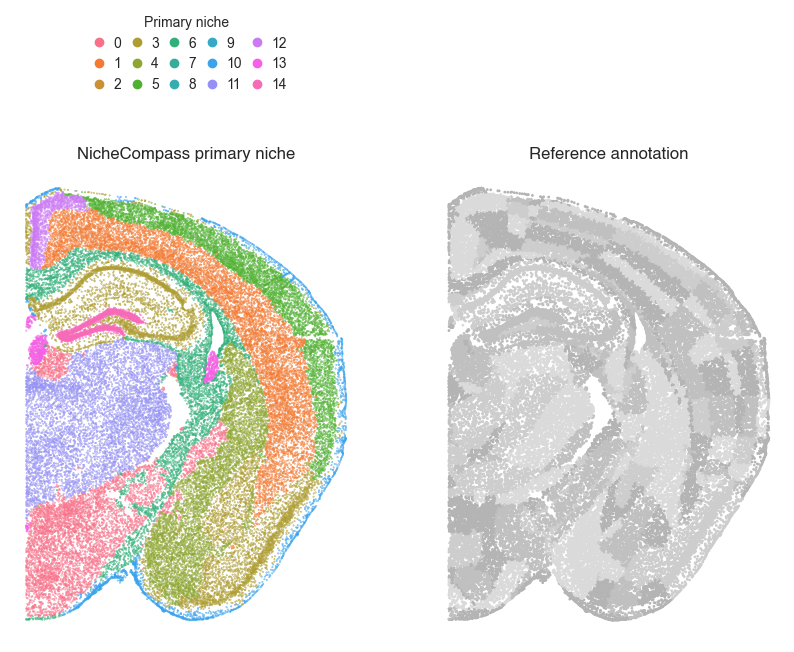

In [25]:
categories = well11_aligned_coordinates["struct_id"].astype(str).fillna("Unknown").unique().tolist()
colours = color_palette(["#b4b4b4", "#c0c0c0", "#cdcdcd", "#dadada"], len(categories))
colour_map = {key: value for key, value in zip(categories, colours)}

categories = well11_adata.obs["nichecompass_latent_cluster"].astype(str).fillna("Unknown").unique().tolist()

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_figheight(20)
fig.set_figwidth(20)

axs[0].scatter(
    [x * -1 for x in well11_aligned_coordinates["y"].tolist()],
    [x * -1 for x in well11_aligned_coordinates["x"].tolist()],
    c=well11_adata.obs["nichecompass_latent_cluster"].astype(str).fillna("Unknown").map(niche_color_map),
    s=0.1
)

axs[1].scatter(
    [x * -1 for x in well11_aligned_coordinates["y"].tolist()],
    [x * -1 for x in well11_aligned_coordinates["x"].tolist()],
    c=well11_aligned_coordinates["struct_id"].astype(str).fillna("Unknown").map(colour_map),
    s=1
)

hfont = {'fontname':'Helvetica'}

axs[0].set_title("NicheCompass primary niche", **hfont)
axs[0].set_aspect('equal')
axs[0].axis('off')

axs[1].set_title("Reference annotation", **hfont)
axs[1].set_aspect('equal')
axs[1].axis('off')

legend_handles = [plt.plot([], marker="o", ls="", color=colour)[0] for colour in niche_color_map.values()]
axs[0].legend(legend_handles, niche_color_map.keys(), bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncols=5, mode="expand", borderaxespad=5, title="Primary niche", handletextpad=0.05, frameon=False)

fig.set_figheight(10)
fig.set_figwidth(10)
